In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# define constants
IMG_SIZE = 100

In [3]:
def conv2d_out_sz(in_size, kernel_size, pool_size, padding=0, stride=1):
    return ((in_size - kernel_size + 2*padding)/stride + 1)/pool_size

In [4]:
ims = IMG_SIZE # image size
ks = 5 # kernel size
ps = 2 # pool size
out_chan = 64

os = conv2d_out_sz(ims,ks,ps) # outputs to the next layer of conv2d
os = conv2d_out_sz(os,ks,ps) # output size 2
os = conv2d_out_sz(os,ks,ps) # output size 3

fcin = int((int(os)**2)*out_chan)
print(fcin)

5184


In [5]:
class WildfireModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.kernel_size = 5
        
        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16,  kernel_size=self.kernel_size)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=self.kernel_size)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size)

        self.fc1 = nn.Linear(fcin, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.leaky_relu(self.conv3(x)), (2,2))
        
        x = x.view(-1, fcin)
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
                    
        x = F.sigmoid(x)
        return x

In [6]:
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
data = np.load("data.npy", allow_pickle=True)

In [8]:
x = torch.tensor([d[0] for d in data])
x = (x/255.0).view(-1,3,100,100)

y = torch.tensor([float(d[1]) for d in data])

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1)
(train_x.shape, train_y.shape), (test_x.shape, test_y.shape)

((torch.Size([514, 3, 100, 100]), torch.Size([514])),
 (torch.Size([58, 3, 100, 100]), torch.Size([58])))

tensor(0.)


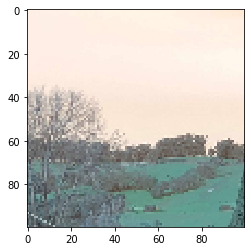

In [9]:
plt.imshow(train_x[0].view(100,100,3))
print(train_y[0])

In [10]:
def evaluate_accuracy(test_x, test_y, wfm):
    correct = []
    incorrect = []

    with torch.no_grad():
        for i in range(len(test_x)):
            real_class = test_y[i]
            output = wfm(test_x[i:i+1])[0] # returns a list, grab the 0th 
            predicted_class = np.round(output.detach())
            if predicted_class == real_class:
                correct += [i]
            else:
                incorrect += [i, real_class]
                
    accuracy = round(len(correct)/(len(correct) + len(incorrect)), 3)
                
    return (accuracy, correct, incorrect)

In [11]:
class BoundedNumericList():
    
    def __init__(self, size):
        self.size = size
        self.nums = []
        self.next_insertion = 0
        
    def insert(self, item):
        if not isinstance(item, (int, float, complex)) or isinstance(item, bool):
            return False
        if len(self.nums) < self.size:
            self.nums += [item]
        else:
            self.nums[self.next_insertion % self.size] = item
        self.next_insertion += 1
        return True

    def average(self):
        if len(self.nums) == 0: return None
        return sum(self.nums) / len(self.nums)

In [ ]:
wfm = WildfireModel()
optimizer = optim.Adam(wfm.parameters(), lr=1e-4)
loss_function = nn.BCELoss()

BATCH_SIZE = 100
EPOCHS = 4000
ROLLING_ACCURACY_SIZE = 4

past_epoch_accuracies = BoundedNumericList(ROLLING_ACCURACY_SIZE)
highest_rolling_accuracy = -1

for epoch in range(EPOCHS):
    for i in range(0, len(train_x), BATCH_SIZE):
        batch_x = train_x[i : i+BATCH_SIZE]
        batch_y = train_y[i : i+BATCH_SIZE]
        batch_y = torch.unsqueeze(batch_y, 1)
        
        wfm.zero_grad()

        outputs = wfm(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    epoch_accuracy,_,_ = evaluate_accuracy(test_x, test_y, wfm)
    past_epoch_accuracies.insert(epoch_accuracy)
    rolling_accuracy = past_epoch_accuracies.average()

    print(f"Epoch: {epoch}. Loss: {loss}. Rolling Accuracy: {round(rolling_accuracy,3)}")
    
    if rolling_accuracy > highest_rolling_accuracy:
        print(f"Saving model at epoch {epoch}.")
        torch.save(wfm, "wfm.pt")
        highest_rolling_accuracy = rolling_accuracy

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0. Loss: 0.7333468794822693. Rolling Accuracy: 0.275
Saving model at epoch 0.


/usr/local/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WildfireModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1. Loss: 0.7251073718070984. Rolling Accuracy: 0.275
Epoch: 2. Loss: 0.7088643312454224. Rolling Accuracy: 0.275
Epoch: 3. Loss: 0.6896524429321289. Rolling Accuracy: 0.322
Saving model at epoch 3.
Epoch: 4. Loss: 0.709032416343689. Rolling Accuracy: 0.336
Saving model at epoch 4.
Epoch: 5. Loss: 0.6953450441360474. Rolling Accuracy: 0.394
Saving model at epoch 5.
Epoch: 6. Loss: 0.6942388415336609. Rolling Accuracy: 0.412
Saving model at epoch 6.
Epoch: 7. Loss: 0.6972090601921082. Rolling Accuracy: 0.468
Saving model at epoch 7.
Epoch: 8. Loss: 0.6917996406555176. Rolling Accuracy: 0.481
Saving model at epoch 8.
Epoch: 9. Loss: 0.6847458481788635. Rolling Accuracy: 0.487
Saving model at epoch 9.
Epoch: 10. Loss: 0.7577024698257446. Rolling Accuracy: 0.481
Epoch: 11. Loss: 0.6842703223228455. Rolling Accuracy: 0.474
Epoch: 12. Loss: 0.7128496170043945. Rolling Accuracy: 0.481
Epoch: 13. Loss: 0.679670512676239. Rolling Accuracy: 0.487
Saving model at epoch 13.
Epoch: 14. Loss: 

Epoch: 124. Loss: 0.44435998797416687. Rolling Accuracy: 0.767
Epoch: 125. Loss: 0.4532008171081543. Rolling Accuracy: 0.758
Epoch: 126. Loss: 0.44314008951187134. Rolling Accuracy: 0.767
Epoch: 127. Loss: 0.44258540868759155. Rolling Accuracy: 0.767
Epoch: 128. Loss: 0.4423987865447998. Rolling Accuracy: 0.767


In [ ]:
wfm = torch.load('wfm.pt')
acc,_,_ = evaluate_accuracy(test_x, test_y, wfm)
print(f"Model accuracy: {acc}")